In [1]:
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import os

# PATHS
BASE_FOLDER = "Prova riconoscimento Calanchi"

BANDS_FOLDER = os.path.join('Prova riconoscimento Calanchi', "Bande")

B02_FILE = os.path.join(BANDS_FOLDER, "T33TUH_20200823T100031_B02_10m.jp2")
B03_FILE = os.path.join(BANDS_FOLDER, "T33TUH_20200823T100031_B03_10m.jp2")
B04_FILE = os.path.join(BANDS_FOLDER, "T33TUH_20200823T100031_B04_10m.jp2")
B08_FILE = os.path.join(BANDS_FOLDER, "T33TUH_20200823T100031_B08_10m.jp2")

SHP_FILE = os.path.join(BASE_FOLDER, "GIS", "Calanchi_2020.shp")

FEATURES_FOLDER = 'features'

BADLANDS = os.path.join(FEATURES_FOLDER, 'badlands.tif')

MASK_NAMES = {
    'mask_b02', 'mask_b03', 'mask_b04', 'mask_ndvi', 'mask_ndwi', 'mask_arvi',
    'mask_evi2', 'mask_msi', 'mask_ngrdi', 'mask_bi', 'mask_and'
}


def load_bands():
    with rasterio.open(B02_FILE) as b02, \
            rasterio.open(B03_FILE) as b03, \
            rasterio.open(B04_FILE) as b04, \
            rasterio.open(B08_FILE) as b08:
        b02 = b02.read(1).astype(np.float32)
        b03 = b03.read(1).astype(np.float32)
        b04 = b04.read(1).astype(np.float32)
        b08 = b08.read(1).astype(np.float32)

        return b02, b03, b04, b08


def load_badlands():
    with rasterio.open(BADLANDS) as badlands:
        return badlands.read(1)


# features
def ndwi(b03, b08):
    return (b03 - b08) / (b03 + b08)


def ndvi(b04, b08):
    return (b08 - b04) / (b08 + b04)


def arvi(b02, b04, b08):
    return (b08 - (2 * b04 - b02)) / (b08 + (2 * b04 - b02))


def evi2(b04, b08):
    return 2.5 * (b08 - b04) / (b08 + 2.4 * b04 + 1)


def msi(b04, b08):
    return (b08 - b04) / (b08 + b04 + 0.5)


def ngrdi(b03, b04):
    return (b03 - b04) / (b03 + b04)


def bi(b02, b03, b04):
    return np.sqrt(b02 ** 2 + b03 ** 2 + b04 ** 2)


# masks
def mask_band(band, min, max):
    return ((band >= min) & (band <= max)).astype(np.uint8)


def mask_ndvi(b04, b08, min, max):
    ndvi_values = ndvi(b04, b08)
    mask = (ndvi_values >= min) & (ndvi_values <= max)
    return mask.astype(np.uint8)


def mask_ndwi(b03, b08, min, max):
    ndwi_values = ndwi(b03, b08)
    mask = (ndwi_values >= min) & (ndwi_values <= max)
    return mask.astype(np.uint8)


def mask_arvi(b02, b04, b08, min, max):
    arvi_values = arvi(b02, b04, b08)
    mask = (arvi_values >= min) & (arvi_values <= max)
    return mask.astype(np.uint8)


def mask_evi2(b04, b08, min, max):
    evi2_values = evi2(b04, b08)
    mask = (evi2_values >= min) & (evi2_values <= max)
    return mask.astype(np.uint8)


def mask_msi(b04, b08, min, max):
    msi_values = msi(b04, b08)
    mask = (msi_values >= min) & (msi_values <= max)
    return mask.astype(np.uint8)


def mask_ngrdi(b03, b04, min, max):
    ngrdi_values = ngrdi(b03, b04)
    mask = (ngrdi_values >= min) & (ngrdi_values <= max)
    return mask.astype(np.uint8)


def mask_bi(b02, b03, b04, min, max):
    bi_values = bi(b02, b03, b04)
    mask = (bi_values >= min) & (bi_values <= max)
    return mask.astype(np.uint8)


def and_masks(masks):
    return np.logical_and.reduce(masks).astype(np.uint8)


class BadlandsAnalyzer:
    def __init__(self, ranges):
        self.b02, self.b03, self.b04, self.b08 = load_bands()

        self.masks = {
            'b02': None,  # Blue Band
            'b03': None,  # Green Band
            'b04': None,  # Red Band
            'ndvi': None,
            'ndwi': None,
            'arvi': None,
            'evi2': None,
            'msi': None,
            'ngrdi': None,
            'bi': None,
            'combined': None
        }

        self.thresholds = {
            'b02': {'min': None, 'max': None},
            'b03': {'min': None, 'max': None},
            'b04': {'min': None, 'max': None},
            'ndvi': {'min': None, 'max': None},
            'ndwi': {'min': None, 'max': None},
            'arvi': {'min': None, 'max': None},
            'evi2': {'min': None, 'max': None},
            'msi': {'min': None, 'max': None},
            'ngrdi': {'min': None, 'max': None},
            'bi': {'min': None, 'max': None}
        }

        self.update_thresholds(ranges)

    def update_thresholds(self, ranges):
        for mask_name, values in ranges.items():
            if mask_name in self.thresholds:
                self.thresholds[mask_name].update(values)

    def compute_masks(self):
        self.masks['b02'] = mask_band(self.b02, **self.thresholds['b02'])
        self.masks['b03'] = mask_band(self.b03, **self.thresholds['b03'])
        self.masks['b04'] = mask_band(self.b04, **self.thresholds['b04'])
        self.masks['ndvi'] = mask_ndvi(self.b04, self.b08, **self.thresholds['ndvi'])
        self.masks['ndwi'] = mask_ndwi(self.b03, self.b08, **self.thresholds['ndwi'])
        self.masks['arvi'] = mask_arvi(self.b02, self.b04, self.b08, **self.thresholds['arvi'])
        self.masks['evi2'] = mask_evi2(self.b04, self.b08, **self.thresholds['evi2'])
        self.masks['msi'] = mask_msi(self.b04, self.b08, **self.thresholds['msi'])
        self.masks['ngrdi'] = mask_ngrdi(self.b03, self.b04, **self.thresholds['ngrdi'])
        self.masks['bi'] = mask_bi(self.b02, self.b03, self.b04, **self.thresholds['bi'])

        # Combine all masks
        all_masks = [
            self.masks['b02'], self.masks['b03'], self.masks['b04'],
            self.masks['ndvi'], self.masks['ndwi'],
            self.masks['arvi'], self.masks['evi2'],
            self.masks['msi'], self.masks['ngrdi'],
            self.masks['bi']
        ]

        self.masks['combined'] = and_masks(all_masks)

    def visualize_masks(self):
        if any(mask is None for mask in self.masks.values()):
            raise ValueError("Run compute_masks() first!")

        # Create a 4x3 grid for 12 subplots (10 masks + combined mask + badlands.tif)
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        axs = axs.ravel()

        # Titles for each mask
        titles = [
            'Red Band Mask', 'Green Band Mask', 'Blue Band Mask',
            'NDVI Mask', 'NDWI Mask', 'ARVI Mask',
            'EVI2 Mask', 'MSI Mask', 'NGRDI Mask', 'BI Mask',
            'Combined Mask', 'BADLANDS TRUTH'
        ]

        # Masks to plot
        masks_to_plot = [
            self.masks['b04'],
            self.masks['b03'],
            self.masks['b02'],
            self.masks['ndvi'],
            self.masks['ndwi'],
            self.masks['arvi'],
            self.masks['evi2'],
            self.masks['msi'],
            self.masks['ngrdi'],
            self.masks['bi'],
            self.masks['combined']
        ]

        for i, (mask, title) in enumerate(zip(masks_to_plot, titles[:-1])):
            axs[i].imshow(mask, cmap='gray', vmin=0, vmax=1)
            axs[i].set_title(title)
            axs[i].axis('off')

        # Load and plot the badlands.tif file
        badlands = load_badlands()
        axs[-1].imshow(badlands, cmap='gray', vmin=0, vmax=1)
        axs[-1].set_title(titles[-1])
        axs[-1].axis('off')

        plt.tight_layout()
        plt.show()

    def get_masks(self):
        return self.masks.copy()


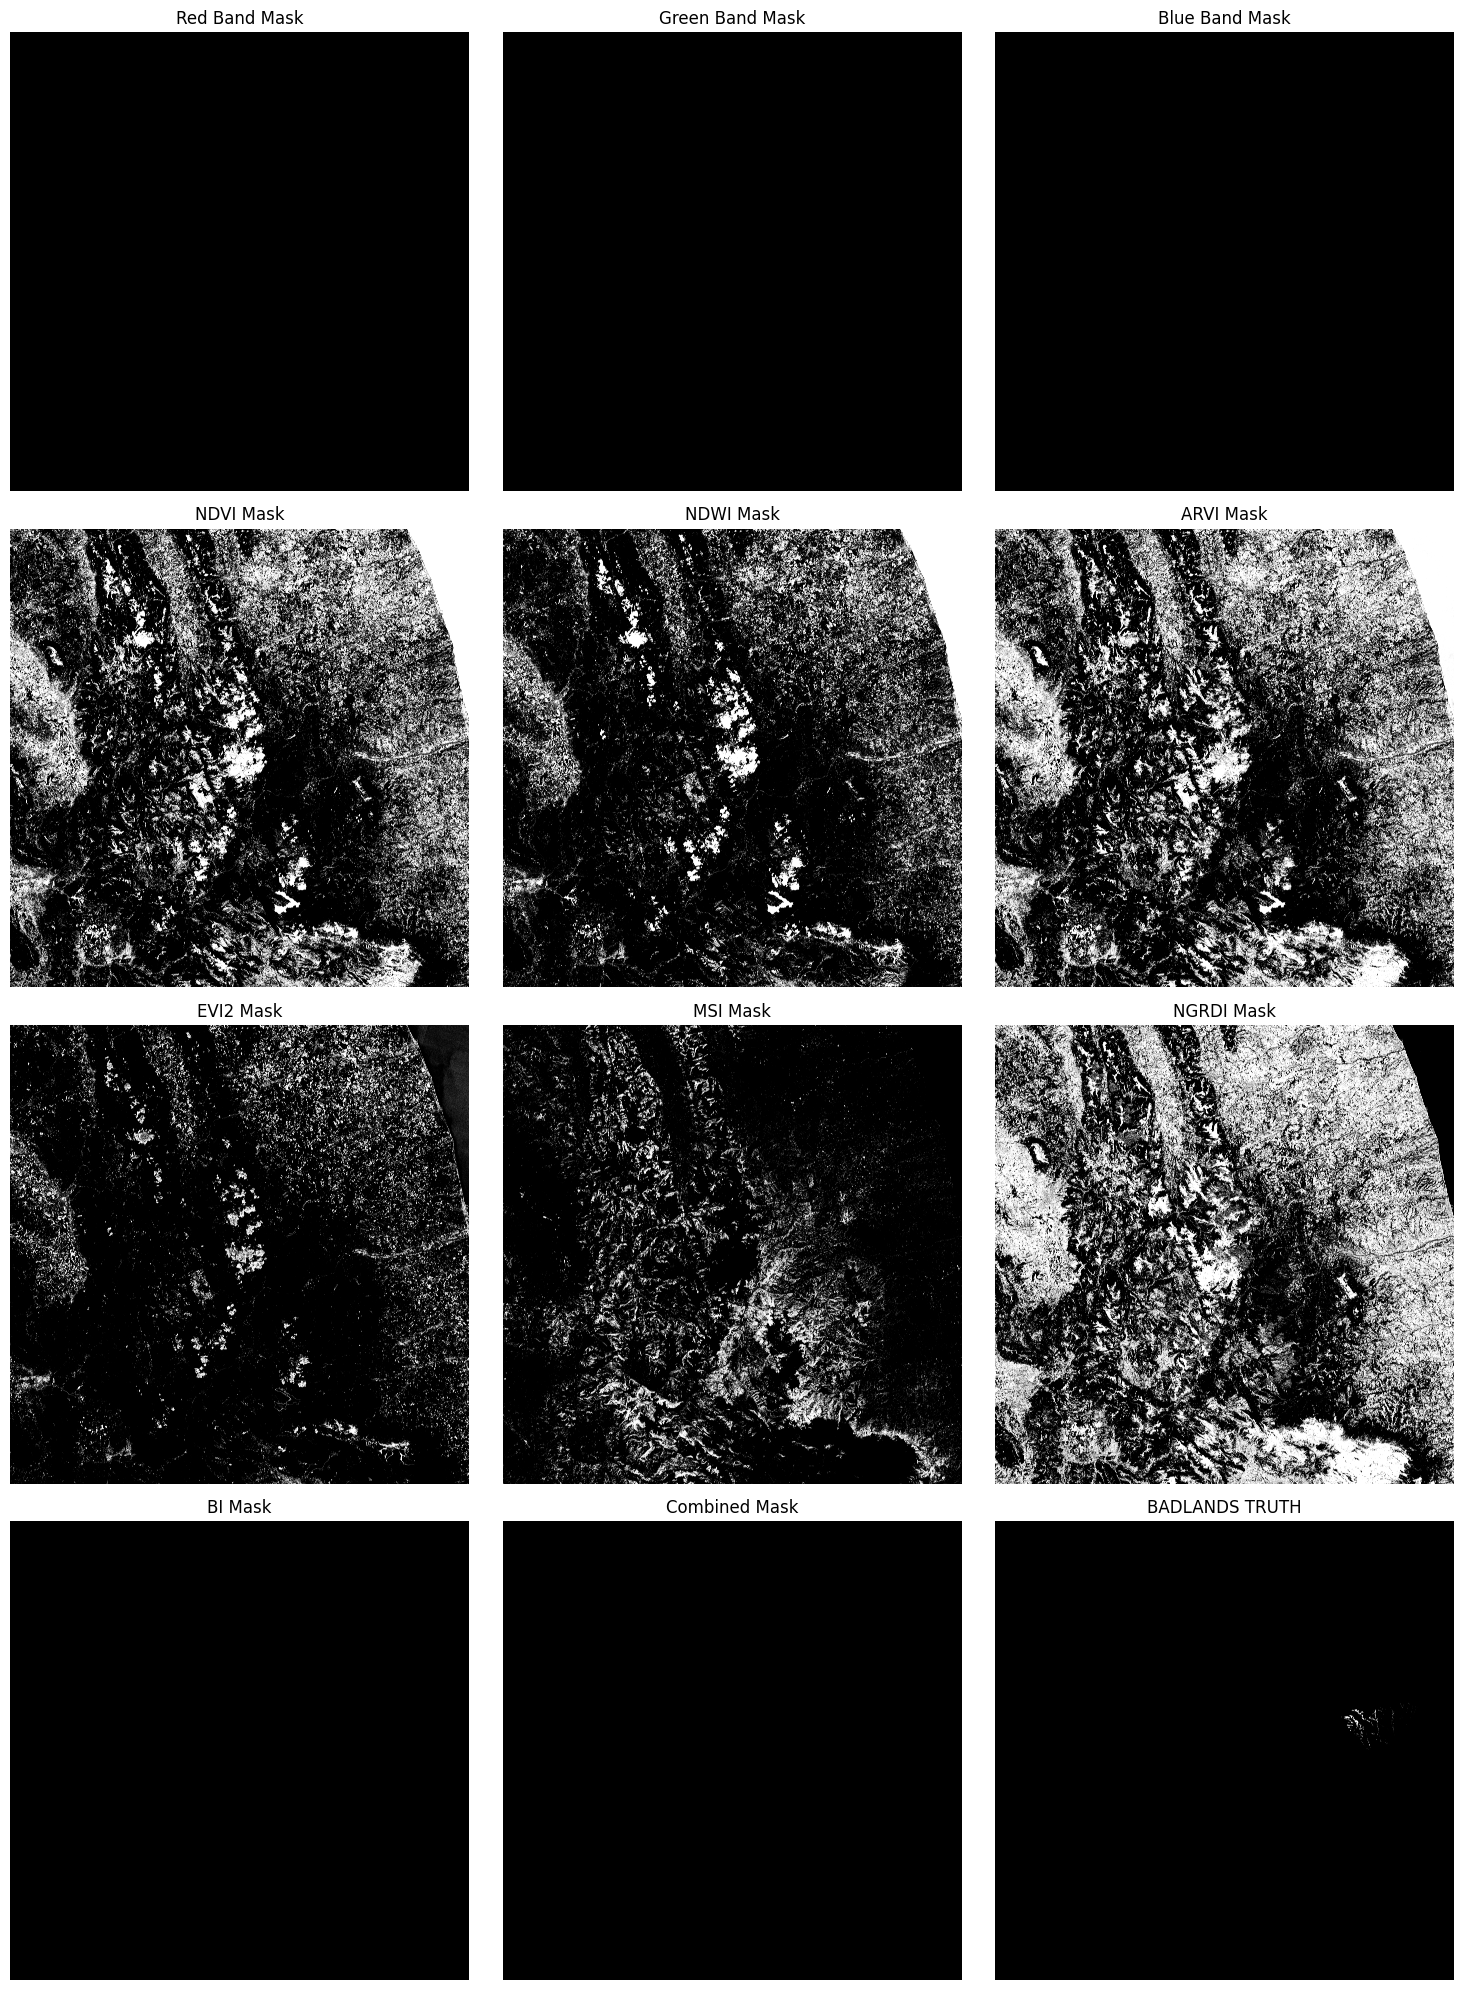

In [3]:
THRESHOLDS = {
    'b02': {'min': 120, 'max': 180},
    'b03': {'min': 140, 'max': 190},
    'b04': {'min': 170, 'max': 220},
    'ndvi': {'min': -0.15, 'max': 0.25},
    'ndwi': {'min': -0.25, 'max': 0.25},
    'arvi': {'min': -0.2, 'max': 0.2},
    'evi2': {'min': 0.0, 'max': 0.2},
    'msi': {'min': 0.6, 'max': 1.5},
    'ngrdi': {'min': -0.1, 'max': 0.0},
    'bi': {'min': 200, 'max': 350}
}

analyzer = BadlandsAnalyzer(THRESHOLDS)
analyzer.compute_masks()
analyzer.visualize_masks()
